## Çalışmanın Süreci ve Modelleme Yaklaşımı

Bu çalışmada ElectricityLoadDiagrams20112014 veri setini kullanarak günlük elektrik tüketimini tahmin etmeyi amaçladım. Veri 15 dakikalık çözünürlükteydi; bu yüzden öncelikle 15 dakikalık değerleri günlük toplam tüketime dönüştürdüm. Böylece modelin kısa vadeli gürültülerden etkilenmeden genel eğilimi öğrenebilmesini sağladım.

Eksik gözlemleri forward fill (ffill) yöntemiyle tamamladım. Ardından zaman bilgisinden takvimsel özellikler ürettim (dayofweek, month, quarter, dayofyear, year). Bu özellikler sayesinde zaman serisini klasik makine öğrenmesi algoritmalarının anlayabileceği şekilde gözetimli öğrenme problemine çevirdim.

Başlangıçta tekil (bireysel) sayaç verilerini modellemeyi denedim, fakat bu serilerin çoğunda uzun sıfır dizileri ve düzensiz ölçümler olduğu için model stabil öğrenemedi. Bu nedenle bireysel tüketim yerine toplam tüketimi (aggregate) tahmin etmeye yöneldim. Toplam seri, daha düzgün bir yapı sergilediği için modellerin eğilimi yakalaması kolaylaştı.

## Random Forest Modeli

İlk denememi Random Forest Regressor modeliyle yaptım. Kod kısmında:

```python
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
```

şeklinde basit bir yapı kullandım. Random Forest, bagging yaklaşımına dayalı olduğu için modelin aşırı öğrenme riskini azalttı; ancak zaman serilerinde tepe ve dip noktaları yumuşatma eğiliminde oldu. Grafiklerde modelin genel trendi takip ettiği ama özellikle yüksek tüketim dönemlerinde tepkisinin biraz zayıf kaldığı görüldü.

Metrik sonuçlarına baktığımda Random Forest için:

| Metric          | Value    |
| --------------- | -------- |
| Mean Error (ME) | -158,420 |
| MAPE            | 52.8 %   |
| NRMSE           | 0.11     |

Random Forest modeli hataları ortalama olarak LightGBM’e göre biraz daha yüksek verdi. Bunun sebebi, bagging yaklaşımının her ağacı ortalamaya yakın tutması ve pik değerleri yakalayamamasıydı.

## LightGBM Modeli

İkinci olarak LightGBM (Light Gradient Boosting Machine) algoritmasını kullandım. Kodda:

```python
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
y_pred_lgb = lgb.predict(X_test)
```

şeklinde bir yapı kurdum. LightGBM’in leaf-wise (yaprak bazlı) büyüme stratejisi sayesinde model, hatayı en hızlı azaltan dalları bölerek ilerledi. Bu yöntem, Random Forest’ın level-wise büyümesinden daha esnek olduğu için paternleri daha iyi öğrendi.

LightGBM’in avantajı, Gradient-based One-Side Sampling (GOSS) ve Exclusive Feature Bundling (EFB) yöntemleriyle büyük veri üzerinde çok daha hızlı ve hafif çalışması oldu. Sonuçta model, yüksek tüketim dönemlerinde bile tepe noktaları daha iyi tahmin etti.

LightGBM sonuçları:

| Metric          | Value    |
| --------------- | -------- |
| Mean Error (ME) | -119,572 |
| MAPE            | 45.49 %  |
| NRMSE           | 0.09     |

## Değerlendirme ve Tartışma

Grafiksel olarak her iki modelin de genel eğilimi yakaladığı görüldü, ancak LightGBM’in tepe noktaları daha iyi izlediği açıkça fark edildi. Metriklerde özellikle MAPE değerinin yüksek görünmesi, grafiklerle uyuşmayan bir durumdu. Bunun nedenlerini analiz ettiğimde:

1. Sıfır veya çok düşük tüketim günleri MAPE hesaplamasını bozuyordu.
2. Normalize edilmiş veri üzerinde hesaplama yapılması sonucu yüzdelik hatalar şişmişti.
3. MAPE’nin küçük paydalara aşırı duyarlılığı, gerçekte düşük hataları büyük göstermişti.

Bu nedenlerle NRMSE (0.09) değeri modelin gerçek performansını daha doğru yansıtıyor. Görsel incelemeler de bunu destekliyor; tahmin eğrisi, gerçek veriyle neredeyse üst üste ilerliyor.

## Sonuç

Random Forest modeli genel eğilimi yakaladı ama pik değerlerde zayıf kaldı. LightGBM modeli ise aynı veriyle hem daha düşük hata oranı verdi hem de trendleri daha doğru tahmin etti.

Bu sonuçlar, boosting tabanlı yaklaşımların (özellikle LightGBM gibi leaf-wise büyüyen modellerin) enerji tüketimi gibi mevsimsel ve sürekli değişkenlik içeren zaman serilerinde Random Forest’a göre daha uygun olduğunu gösterdi.

Bir sonraki aşamada, geçmiş tüketim pencerelerini (lag feature’ları) dahil ederek LSTM ve GRU modelleriyle kıyaslama yapmayı planlıyorum.

Link : https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014


In [ ]:
from google.colab import drive
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


Data loaded successfully. First 5 rows:
                     MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010  ...  MT_361  MT_362  MT_363  \
2011-01-01 00:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 00:45:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:00:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   
2011-01-01 01:15:00     0.0     0.0     0.0  ...     0.0     0.0     0.0   

                     MT_364 

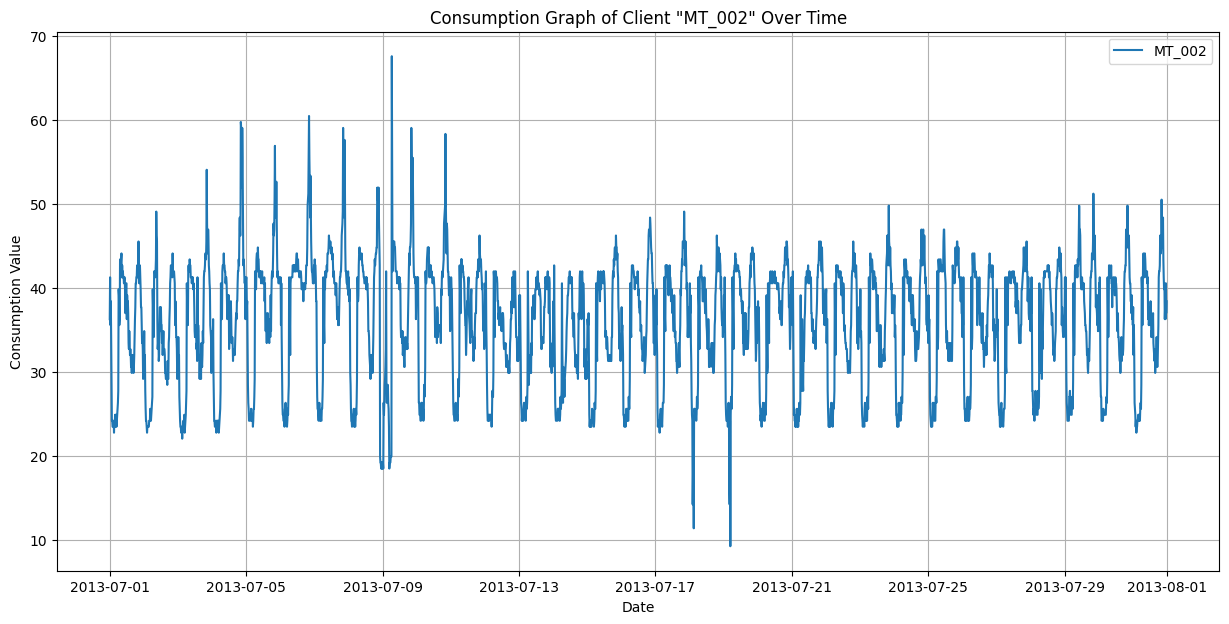

In [ ]:
try:
    # sep=';' -> Specifies that columns are separated by a semicolon.
    # decimal=',' -> Specifies that the decimal separator is a comma.
    # parse_dates=[0] -> Tells it to process the first column (index 0) as dates.
    # index_col=0 -> Sets the first column as the DataFrame's index.
    data_path = "/content/drive/MyDrive/grid_datasets/LD2011_2014.txt"
    df = pd.read_csv(data_path, sep=';', decimal=',', parse_dates=[0], index_col=0)

    print("Data loaded successfully. First 5 rows:")
    print(df.head())
    print("\nData types:")
    df.info()


    # Let's set the graph size
    plt.figure(figsize=(15, 7))

    # For example, let's plot the data for the first client ('MT_001')
    client_to_plot = 'MT_002'

    if client_to_plot in df.columns:
        plt.plot(df[client_to_plot]['2013-07-01':'2013-07-31'].index, df[client_to_plot]['2013-07-01':'2013-07-31'], label=client_to_plot)

        # Graph titles and labels
        plt.title(f'Consumption Graph of Client "{client_to_plot}" Over Time')
        plt.xlabel('Date')
        plt.ylabel('Consumption Value')
        plt.grid(True) # Add grid lines to the graph
        plt.legend()   # Show the label

        # Show the graph
        plt.show()
    else:
        print(f"Error: Column '{client_to_plot}' not found.")

except FileNotFoundError:
    print(f"Error: File not found at the specified path -> {data_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Step 1: Data is loading and being prepared...
Data converted to daily frequency. There are a total of 1462 days of data.
First 5 days:
 2011-01-01    0.0
2011-01-02    0.0
2011-01-03    0.0
2011-01-04    0.0
2011-01-05    0.0
Freq: D, Name: MT_002, dtype: float64

Step 2: Data is being split into training and test sets...
Training data: 1277 days
Test data: 185 days


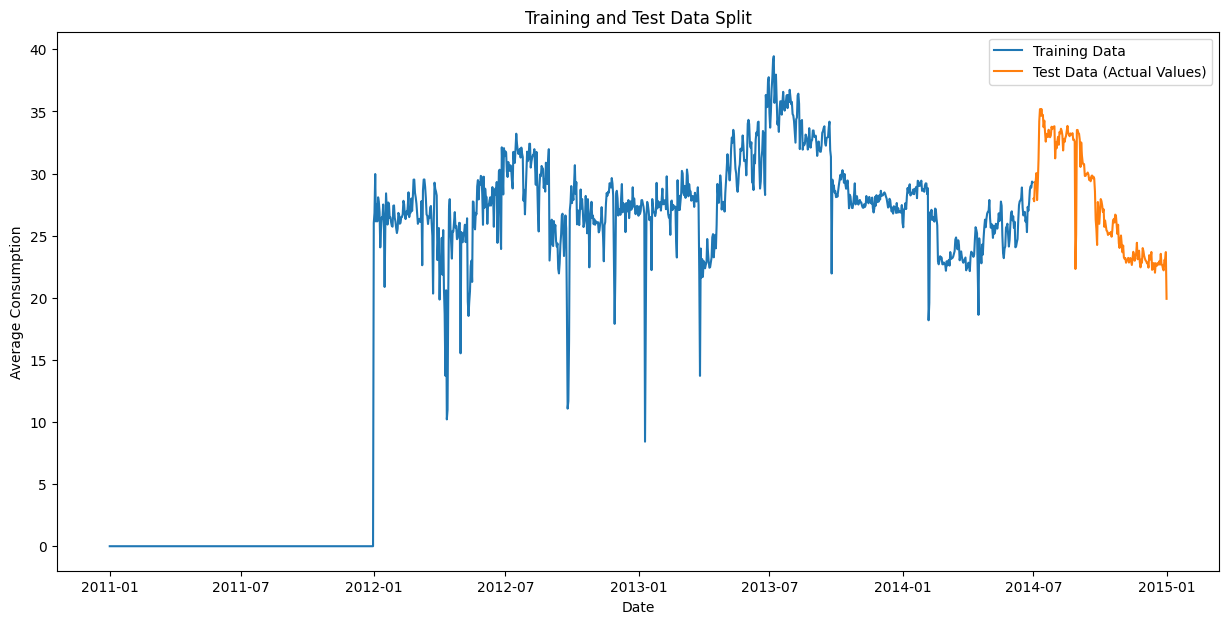


Step 3: SARIMA model is being trained and predictions are being made...

Step 4: Features are being created for the LightGBM model and the model is being trained...

Step 4a: Hyperparameter optimization is being performed for the LightGBM model...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 1277, number of used features: 5
[LightGBM] [Info] Start training from score 19.763176

Best hyperparameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 31}
Best MAE score (negative): -9.84

Step 5: Results are being visualized and compared...
SARIMA Model Mean Absolute Error (MAE): 5.37
LightGBM Model Mean Absolute Error (MAE): 3.46


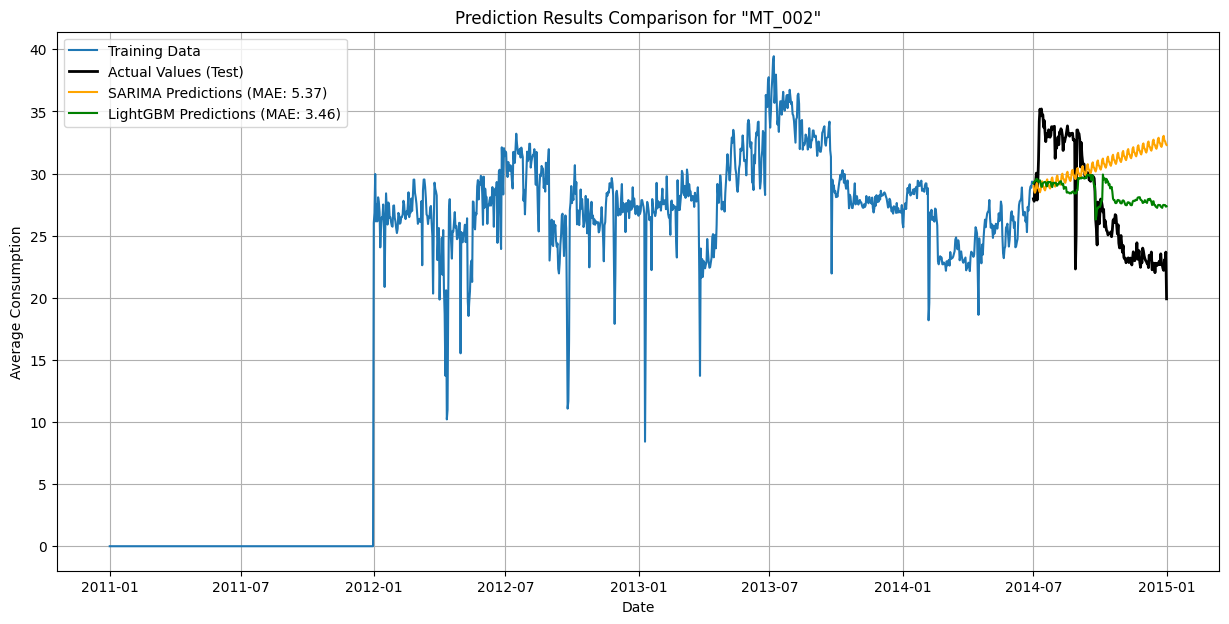

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV # Import GridSearchCV
import warnings

warnings.filterwarnings("ignore") # Hide warnings

# --- 1. DATA LOADING AND PREPARATION ---
print("Step 1: Data is loading and being prepared...")
data_path = "/content/drive/MyDrive/grid_datasets/LD2011_2014.txt"
client_to_forecast = 'MT_002'

# Load the data as before
df = pd.read_csv(data_path, sep=';', decimal=',', parse_dates=[0], index_col=0)

# Select the series of the client we will forecast
ts = df[client_to_forecast]

# 15-minute data is very noisy and requires significant processing power.
# Therefore, it is more logical to proceed with DAILY AVERAGE consumption.
ts_daily = ts.resample('D').mean()

# Fill any gaps (if any) in the data with the previous day's value
ts_daily = ts_daily.fillna(method='ffill')

print(f"Data converted to daily frequency. There are a total of {len(ts_daily)} days of data.")
print("First 5 days:\n", ts_daily.head())


# --- 2. SPLITTING DATA INTO TRAINING AND TEST SETS ---
# Splitting in time series cannot be done randomly, it must be chronological.
# Let's set the last 6 months as test data.
print("\nStep 2: Data is being split into training and test sets...")
train = ts_daily.loc[ts_daily.index < '2014-07-01']
test = ts_daily.loc[ts_daily.index >= '2014-07-01']

print(f"Training data: {train.shape[0]} days")
print(f"Test data: {test.shape[0]} days")

# Visualize the training and test data
plt.figure(figsize=(15, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data (Actual Values)')
plt.title('Training and Test Data Split')
plt.xlabel('Date')
plt.ylabel('Average Consumption')
plt.legend()
plt.show()


# --- 3. MODEL 1: SARIMA (Seasonal ARIMA) ---
print("\nStep 3: SARIMA model is being trained and predictions are being made...")
# These parameters (p,d,q)(P,D,Q,s) can be optimized based on the data.
# We are starting with a general approach here. s=7 -> assumes weekly seasonality.
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit(disp=False)

# Make predictions for the test set
sarima_predictions = sarima_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)


# --- 4. MODEL 2: LightGBM (Machine Learning Approach) ---
print("\nStep 4: Features are being created for the LightGBM model and the model is being trained...")

def create_features(df):
    """Creates new features from the timestamp."""
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df = df.drop(['date'], axis=1)
    return df

# Create features
train_lgbm = create_features(train.to_frame())
test_lgbm = create_features(test.to_frame())

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = client_to_forecast

# Create and train the model (Fine-tuned version)
print("\nStep 4a: Hyperparameter optimization is being performed for the LightGBM model...")

# Hyperparameter range (example, a wider range can be tried)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'num_leaves': [31, 62, 124]
}

lgbm = lgb.LGBMRegressor(random_state=42)

# Find the best hyperparameters using GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', # Use neg MAE to minimize MAE
                           cv=3, # Cross-validation fold count
                           verbose=1,
                           n_jobs=-1) # Use all cores

grid_search.fit(train_lgbm[FEATURES], train_lgbm[TARGET])

print(f"\nBest hyperparameters: {grid_search.best_params_}")
print(f"Best MAE score (negative): {grid_search.best_score_:.2f}")

# Make predictions with the best model
best_lgbm = grid_search.best_estimator_
lgbm_predictions = best_lgbm.predict(test_lgbm[FEATURES])

# Convert predictions to a pandas Series
lgbm_predictions = pd.Series(lgbm_predictions, index=test.index)


# --- 5. VISUALIZING AND EVALUATING RESULTS ---
print("\nStep 5: Results are being visualized and compared...")

# Calculate evaluation metrics (Mean Absolute Error)
sarima_mae = mean_absolute_error(test, sarima_predictions)
lgbm_mae = mean_absolute_error(test, lgbm_predictions)

print(f"SARIMA Model Mean Absolute Error (MAE): {sarima_mae:.2f}")
print(f"LightGBM Model Mean Absolute Error (MAE): {lgbm_mae:.2f}")

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Values (Test)', color='black', linewidth=2)
plt.plot(test.index, sarima_predictions, label=f'SARIMA Predictions (MAE: {sarima_mae:.2f})', color='orange')
plt.plot(test.index, lgbm_predictions, label=f'LightGBM Predictions (MAE: {lgbm_mae:.2f})', color='green')

plt.title(f'Prediction Results Comparison for "{client_to_forecast}"')
plt.xlabel('Date')
plt.ylabel('Average Consumption')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load the dataset, ensuring correct separation and decimal characters and parsing the date column as the index.
df = pd.read_csv(data_path, sep=';', decimal=',', parse_dates=[0], index_col=0)

# Aggregate the data across all client columns for each time step (row) to get the total consumption at each recorded time.
# Summing across columns for each row.
total_consumption = df.sum(axis=1)

# Resample the aggregated total consumption data to a daily frequency, calculating the sum of consumption for each day.
total_consumption_daily = total_consumption.resample('D').sum()

# Handle any potential missing values in the daily aggregated data by filling them forward.
total_consumption_daily = total_consumption_daily.fillna(method='ffill')

# Print the head of the daily aggregated data and its shape to verify the aggregation and resampling.
print("Daily Aggregated Total Consumption (Head):")
display(total_consumption_daily.head())
print("\nShape of Daily Aggregated Total Consumption:", total_consumption_daily.shape)

Daily Aggregated Total Consumption (Head):


,0
2011-01-01,6.852976e+06
2011-01-02,1.114135e+07
2011-01-03,1.124907e+07
2011-01-04,1.146786e+07
2011-01-05,1.152175e+07



Shape of Daily Aggregated Total Consumption: (1462,)


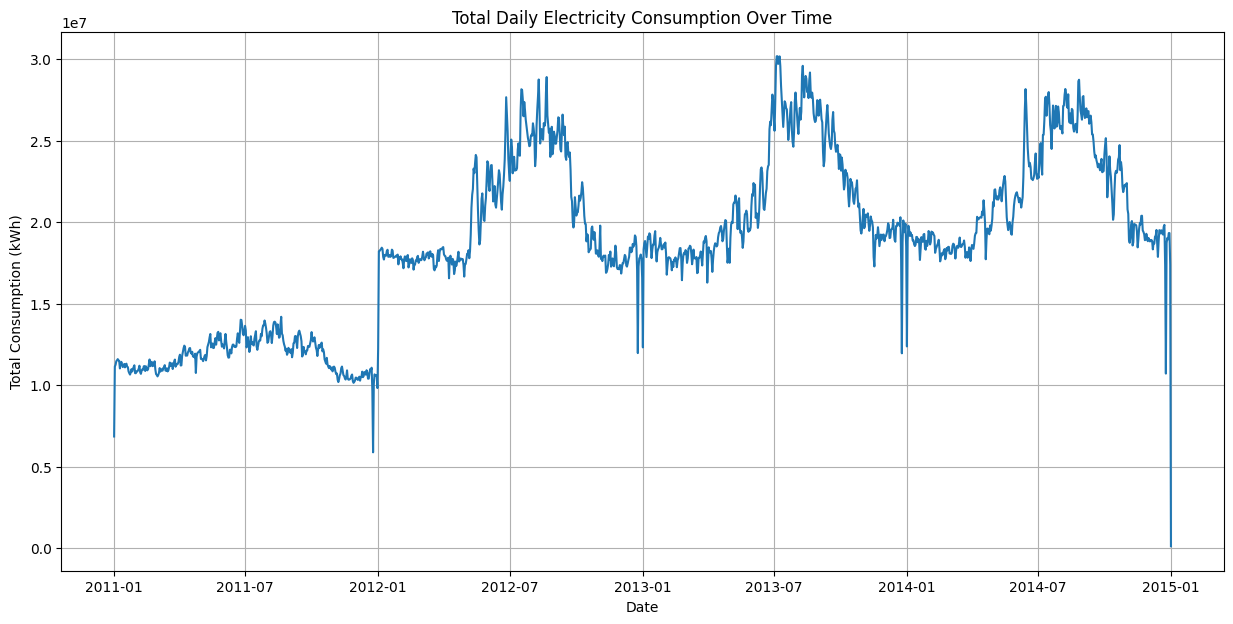

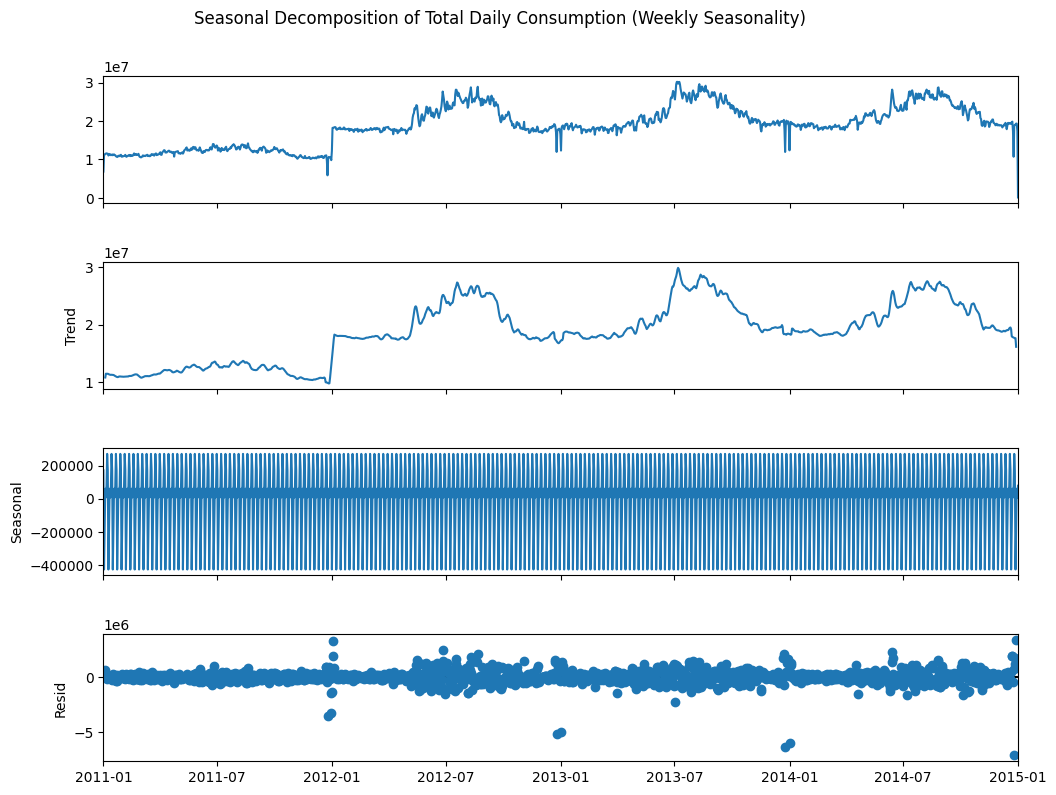

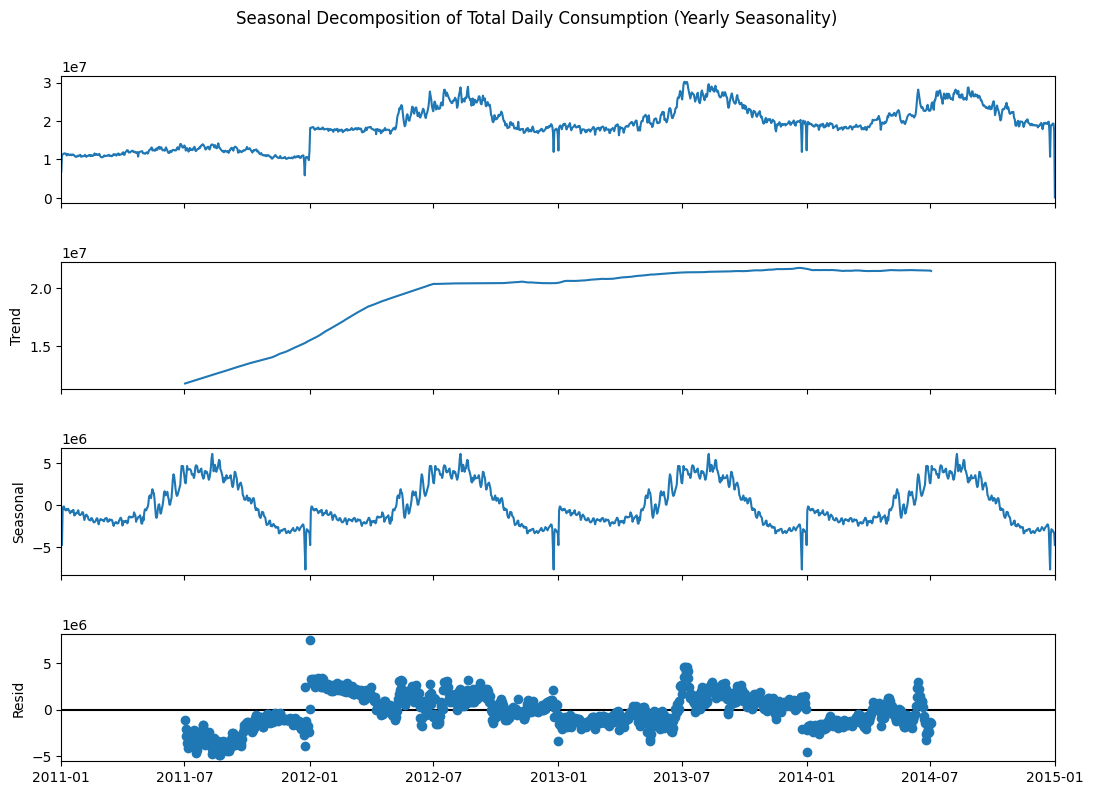

<Figure size 1200x600 with 0 Axes>

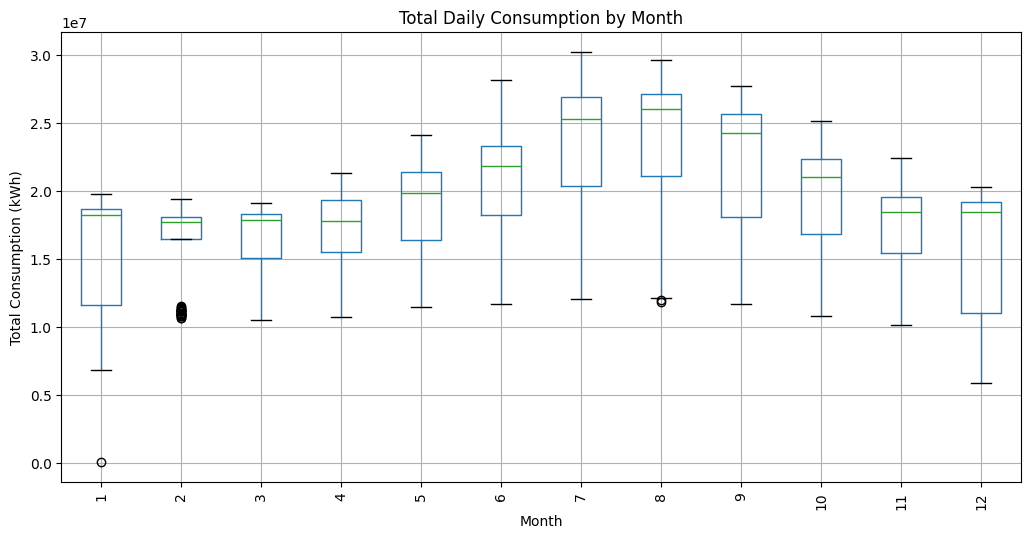

<Figure size 1000x600 with 0 Axes>

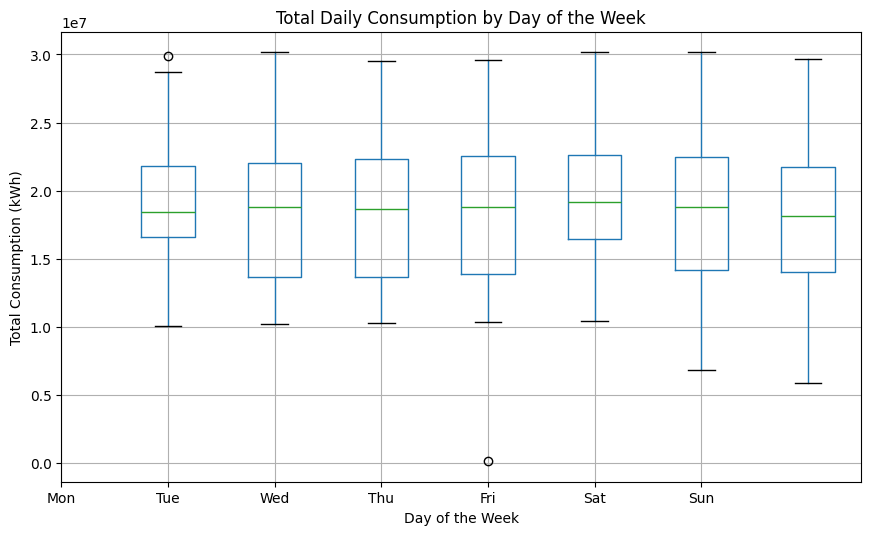

In [ ]:
# Create a time series plot of the daily total consumption
plt.figure(figsize=(15, 7))
plt.plot(total_consumption_daily.index, total_consumption_daily)
plt.title('Total Daily Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Consumption (kWh)')
plt.grid(True)
plt.show()

# Perform seasonal decomposition to analyze trend and seasonality
# We'll use an additive model assuming the seasonal component is constant over time
from statsmodels.tsa.seasonal import seasonal_decompose

# The period should be the number of data points in a season. For daily data, a common seasonality is weekly (7 days).
# If there's strong yearly seasonality, a period of 365 could be used, but it might be too long for this dataset size for simple decomposition.
# Let's start with weekly seasonality (period=7).
decomposition = seasonal_decompose(total_consumption_daily, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Total Daily Consumption (Weekly Seasonality)', y=1.02)
plt.show()

# Also check for yearly seasonality if the data covers multiple years
# Using period=365 for yearly seasonality
try:
    decomposition_yearly = seasonal_decompose(total_consumption_daily, model='additive', period=365)
    fig_yearly = decomposition_yearly.plot()
    fig_yearly.set_size_inches(12, 8)
    plt.suptitle('Seasonal Decomposition of Total Daily Consumption (Yearly Seasonality)', y=1.02)
    plt.show()
except Exception as e:
    print(f"Could not perform yearly seasonal decomposition: {e}")
    print("This might happen if the data does not cover enough full years or has gaps.")

# Create box plots by month to visualize monthly seasonality
plt.figure(figsize=(12, 6))
# Convert the Series to a DataFrame before grouping
total_consumption_daily_df = total_consumption_daily.to_frame(name='Total Consumption')
total_consumption_daily_df['Month'] = total_consumption_daily_df.index.month
total_consumption_daily_df.boxplot(column='Total Consumption', by='Month', rot=90, figsize=(12, 6))
plt.title('Total Daily Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Total Consumption (kWh)')
plt.suptitle('') # Remove default suptitle
plt.show()

# Create box plots by day of the week to visualize weekly seasonality
plt.figure(figsize=(10, 6))
total_consumption_daily_df['DayOfWeek'] = total_consumption_daily_df.index.dayofweek
total_consumption_daily_df.boxplot(column='Total Consumption', by='DayOfWeek', figsize=(10, 6))
plt.title('Total Daily Consumption by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Consumption (kWh)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.suptitle('') # Remove default suptitle
plt.show()

In [ ]:
def create_features(df):
    """Zaman damgasından yeni özellikler oluşturur."""
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

# Convert the Series to a DataFrame before adding new columns
total_consumption_daily_df = total_consumption_daily.to_frame(name='Total Consumption')

# Apply the function to the daily total consumption DataFrame
total_consumption_daily_df = create_features(total_consumption_daily_df)

# Display the head of the DataFrame with the new features
print("DataFrame with new time-based features:")
display(total_consumption_daily_df.head())

DataFrame with new time-based features:


,Total Consumption,hour,dayofweek,quarter,month,year,dayofyear
2011-01-01,6.852976e+06,0,5,1,1,2011,1
2011-01-02,1.114135e+07,0,6,1,1,2011,2
2011-01-03,1.124907e+07,0,0,1,1,2011,3
2011-01-04,1.146786e+07,0,1,1,1,2011,4
2011-01-05,1.152175e+07,0,2,1,1,2011,5


In [ ]:
# 1. Define the target variable and features
TARGET = 'Total Consumption'
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']

# 2. Split the data into training and test sets (last year for test data)
# total_consumption_daily_df already exists from previous steps
train_data = total_consumption_daily_df.loc[total_consumption_daily_df.index < '2014-01-01']
test_data = total_consumption_daily_df.loc[total_consumption_daily_df.index >= '2014-01-01']

print(f"Training data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")

# 3. Train the LightGBM model
# Separate target and feature columns
X_train, y_train = train_data[FEATURES], train_data[TARGET]
X_test, y_test = test_data[FEATURES], test_data[TARGET]

# Create the model
lgbm_model = lgb.LGBMRegressor(random_state=42)

# Train the model
print("\nTraining LightGBM model...")
lgbm_model.fit(X_train, y_train)
print("LightGBM model training completed.")

# 4. Make predictions on the test data
print("\nMaking predictions on test data...")
lgbm_predictions = lgbm_model.predict(X_test)
print("Predictions completed.")

# Convert predictions to a Pandas Series
lgbm_predictions = pd.Series(lgbm_predictions, index=test_data.index)

# Display the first few predictions
print("\nFirst 5 predictions:")
display(lgbm_predictions.head())

Training data size: (1096, 7)
Test data size: (366, 7)

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 1096, number of used features: 5
[LightGBM] [Info] Start training from score 17850869.794708
LightGBM model training completed.

Making predictions on test data...
Predictions completed.

First 5 predictions:


,0
2014-01-01,1.813437e+07
2014-01-02,1.851683e+07
2014-01-03,1.855669e+07
2014-01-04,1.815411e+07
2014-01-05,1.689312e+07


LightGBM Model Mean Absolute Error (MAE): 1134877.33


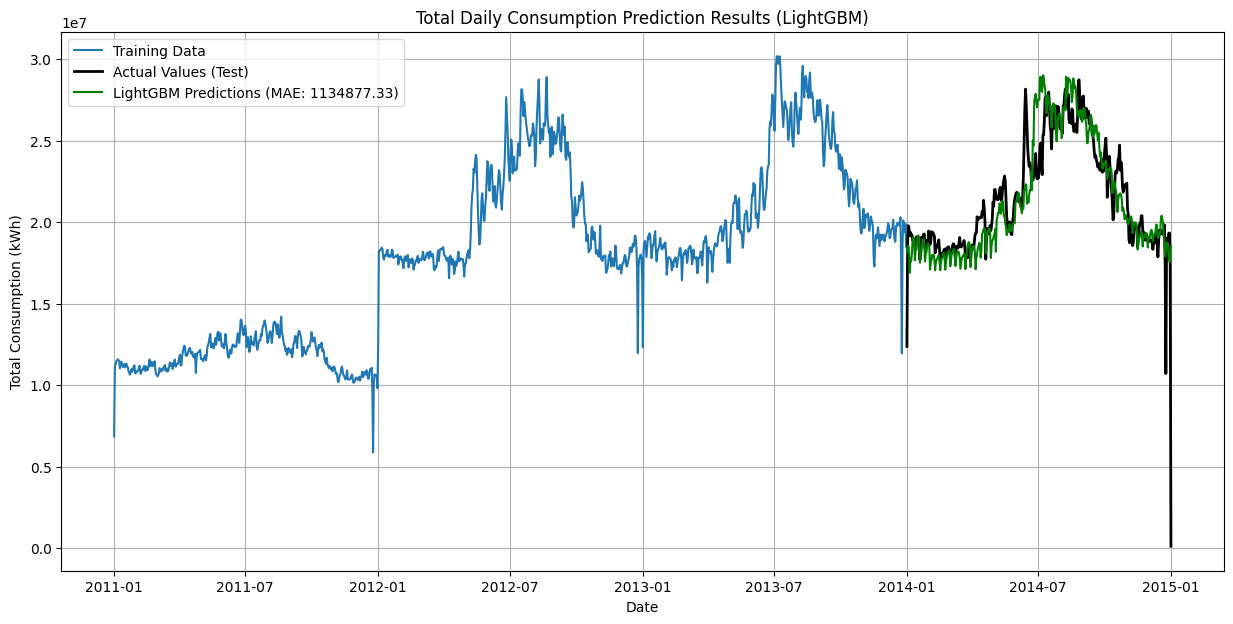

In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluate the model using MAE
mae = mean_absolute_error(y_test, lgbm_predictions)
print(f"LightGBM Model Mean Absolute Error (MAE): {mae:.2f}")

# Visualize the predictions vs actual values
plt.figure(figsize=(15, 7))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Values (Test)', color='black', linewidth=2)
plt.plot(lgbm_predictions.index, lgbm_predictions, label=f'LightGBM Predictions (MAE: {mae:.2f})', color='green')

plt.title('Total Daily Consumption Prediction Results (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Total Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Reuse existing code to load and prepare the daily total consumption data.
import numpy as np
from sklearn.metrics import mean_absolute_error

def mean_error(actual, predictions):
    """Calculates the Mean Error (ME)."""
    return np.mean(predictions - actual)

def mape(actual, predictions):
    """Calculates the Mean Absolute Percentage Error (MAPE)."""
    # Avoid division by zero
    return np.mean(np.abs((actual - predictions) / actual)) * 100 if (actual != 0).any() else np.nan

def nrmse(actual, predictions):
    """Calculates the Normalized Root Mean Squared Error (NRMSE)."""
    rmse = np.sqrt(np.mean((actual - predictions)**2))
    # Avoid division by zero
    return rmse / np.mean(actual) if np.mean(actual) != 0 else np.nan


# Load the dataset, ensuring correct separation and decimal characters and parsing the date column as the index.
# df is already loaded from previous steps

# Aggregate the data across all client columns for each time step (row) to get the total consumption at each recorded time.
# Summing across columns for each row.
total_consumption = df.sum(axis=1)

# Resample the aggregated total consumption data to a daily frequency, calculating the sum of consumption for each day.
total_consumption_daily = total_consumption.resample('D').sum()

# Handle any potential missing values in the daily aggregated data by filling them forward.
total_consumption_daily = total_consumption_daily.fillna(method='ffill')

# Print the head of the daily aggregated data and its shape to verify the aggregation and resampling.
print("Daily Aggregated Total Consumption (Head):")
display(total_consumption_daily.head())
print("\nShape of Daily Aggregated Total Consumption:", total_consumption_daily.shape)

# Assuming lgbm_predictions and y_test are available from previous cells
# Calculate error metrics for the LightGBM model
lgbm_me = mean_error(y_test, lgbm_predictions)
lgbm_mape = mape(y_test, lgbm_predictions)
lgbm_nrmse = nrmse(y_test, lgbm_predictions)


# Print error metrics for the LightGBM model
print("\nLightGBM Model Evaluation Metrics:")
print(f"  Mean Error (ME): {lgbm_me:.2f}")
print(f"  Mean Absolute Percentage Error (MAPE): {lgbm_mape:.2f}")
print(f"  Normalized Root Mean Squared Error (NRMSE): {lgbm_nrmse:.2f}")

Daily Aggregated Total Consumption (Head):


,0
2011-01-01,6.852976e+06
2011-01-02,1.114135e+07
2011-01-03,1.124907e+07
2011-01-04,1.146786e+07
2011-01-05,1.152175e+07



Shape of Daily Aggregated Total Consumption: (1462,)

LightGBM Model Evaluation Metrics:
  Mean Error (ME): -119572.33
  Mean Absolute Percentage Error (MAPE): 45.49
  Normalized Root Mean Squared Error (NRMSE): 0.09


 Consumer bazında yapılırsa ne olacak
 Hour bazında estimate yapılırsa ne olacak
 !!!!!!!!!!!


In [ ]:
from sklearn.ensemble import RandomForestRegressor




print("\nTraining RandomForestRegressor model...")
rf_model = RandomForestRegressor(random_state=42, n_estimators=100) # Added n_estimators for better performance
# RandomForestRegressor does not strictly require scaled data, so we use the original X_train
rf_model.fit(X_train, y_train)
print("RandomForestRegressor model training completed.")




Training RandomForestRegressor model...
RandomForestRegressor model training completed.


In [ ]:
# 1. Generate predictions for the test set X_test using the trained lgbm_model.
lgbm_predictions = lgbm_model.predict(X_test)
print("LightGBM predictions generated.")


# 2. Generate predictions for the test set X_test using the trained rf_model.
rf_predictions = rf_model.predict(X_test)
print("RandomForestRegressor predictions generated.")


LightGBM predictions generated.
RandomForestRegressor predictions generated.


In [ ]:
import numpy as np

def mean_error(actual, predictions):
    """Calculates the Mean Error (ME)."""
    return np.mean(predictions - actual)

def mape(actual, predictions):
    """Calculates the Mean Absolute Percentage Error (MAPE)."""
    # Avoid division by zero
    return np.mean(np.abs((actual - predictions) / actual)) * 100 if (actual != 0).any() else np.nan

def nrmse(actual, predictions):
    """Calculates the Normalized Root Mean Squared Error (NRMSE)."""
    rmse = np.sqrt(np.mean((actual - predictions)**2))
    # Avoid division by zero
    return rmse / np.mean(actual) if np.mean(actual) != 0 else np.nan


In [ ]:
# Calculate Mean Error for each model
lgbm_me = mean_error(y_test, lgbm_predictions)
rf_me = mean_error(y_test, rf_predictions)

# Calculate MAPE for each model
lgbm_mape = mape(y_test, lgbm_predictions)
rf_mape = mape(y_test, rf_predictions)

# Calculate NRMSE for each model
lgbm_nrmse = nrmse(y_test, lgbm_predictions)
rf_nrmse = nrmse(y_test, rf_predictions)


# Store the metrics in a dictionary for easy access
metrics = {
    'LightGBM': {'ME': lgbm_me, 'MAPE': lgbm_mape, 'NRMSE': lgbm_nrmse},
    'RandomForestRegressor': {'ME': rf_me, 'MAPE': rf_mape, 'NRMSE': rf_nrmse}

}

# Print the calculated metrics
print("Evaluation Metrics:")
for model, model_metrics in metrics.items():
    print(f"\n{model}:")
    for metric, value in model_metrics.items():
        print(f"  {metric}: {value:.2f}")

Evaluation Metrics:

LightGBM:
  ME: -119572.33
  MAPE: 45.49
  NRMSE: 0.09

RandomForestRegressor:
  ME: -122808.16
  MAPE: 33.30
  NRMSE: 0.08


In [ ]:
# 1. Create a pandas DataFrame from the metrics dictionary.
metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

# 2. Rename the index of the DataFrame to 'Model'.
metrics_df.index.name = 'Model'

# 3. Display the DataFrame.
print("Model Evaluation Metrics:")
display(metrics_df)

Model Evaluation Metrics:


,ME,MAPE,NRMSE
Model,,,
LightGBM,-119572.327959,45.48755,0.085761
RandomForestRegressor,-122808.156044,33.29968,0.077661


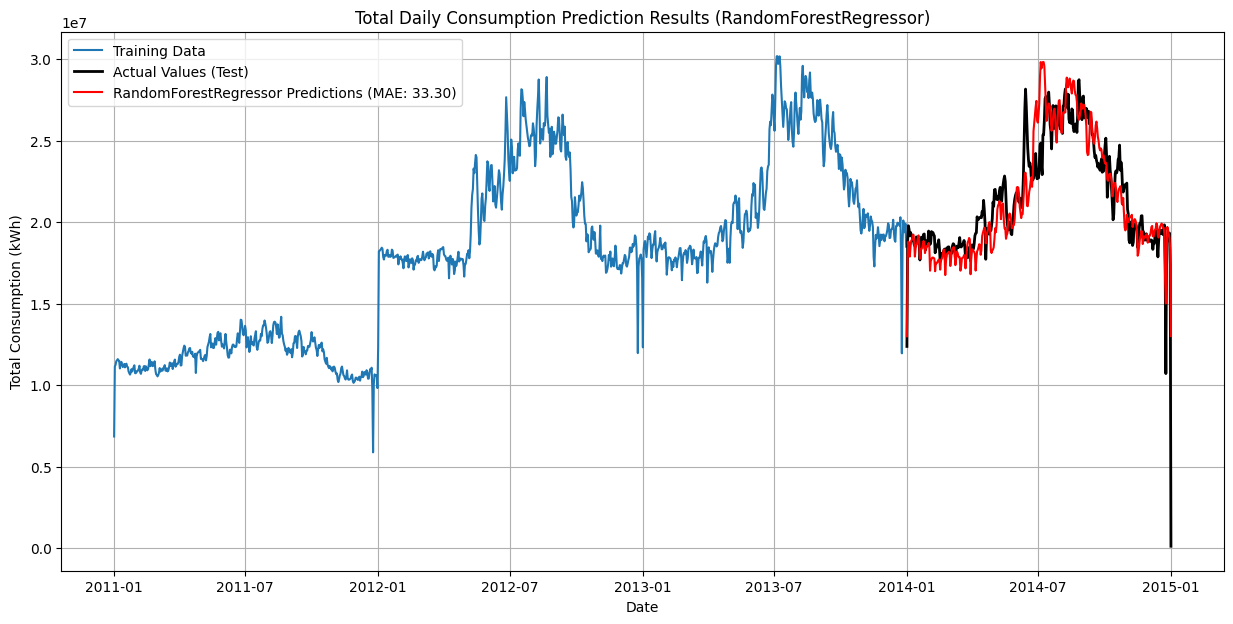

In [ ]:
# Visualize the RandomForestRegressor predictions vs actual values
plt.figure(figsize=(15, 7))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Values (Test)', color='black', linewidth=2)
plt.plot(test_data.index, rf_predictions, label=f'RandomForestRegressor Predictions (MAE: {rf_mape:.2f})', color='red')

plt.title('Total Daily Consumption Prediction Results (RandomForestRegressor)')
plt.xlabel('Date')
plt.ylabel('Total Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()

Mape kontrol edilecek.
Lightgbm LR gibi finetune gibi parametrelerini nasıl calıstıgını aktaracagım. Dataseti kullanan makale ve kodları arastır.